# **Automatic Ticket Assignment**




---



**Business Understanding**
> In any IT industry, Incident Management plays an important role in delivering 
quality support to customers. An incident ticket is created by various groups of people within the organization to resolve an issue as quickly as possible based on its severity. Whenever an incident is created, it reaches the Service desk team and then it gets assigned to the respective teams to work on the incident.

> The Service Desk team (L1/L2) will perform basic analysis on the user's requirement, identify the issue based on given descriptions and assign it to the respective teams.

The manual assignment of these incidents might have below disadvantages: 

*   More resource usage and expenses.
*   Human errors - Incidents get assigned to the wrong assignment groups
*   Delay in assigning the tickets More resolution times
*   If a particular ticket takes more time in analysis, other productive tasks get affected for the Service Desk


> Advantages of Automation:
If this ticket assignment is automated, it can be more cost-effective, less resolution time and the Service Desk team can focus on other productive tasks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import nltk
import re
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import string

import math
from sklearn.preprocessing import LabelEncoder

data = pd.read_excel("input_data.xlsx")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### **Exploratory Data Analysis**

In [ ]:
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
print(f"Shape of dataset:",np.shape(data)) 
print(f"Number of assignmet groups are:", data['Assignment group'].nunique())

Shape of dataset: (8500, 4)
Number of assignmet groups are: 74


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]), <a list of 74 Text major ticklabel objects>)

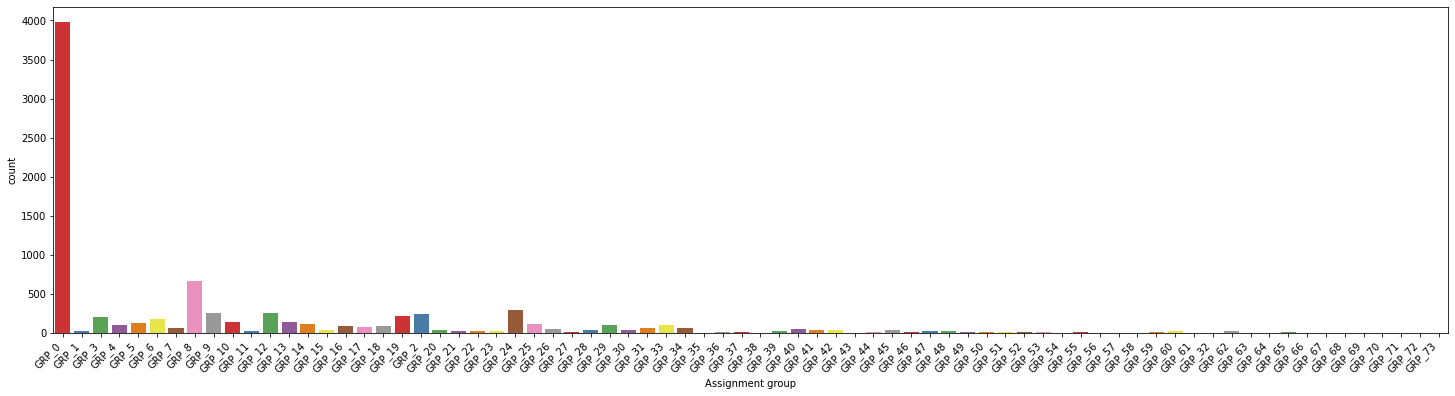

In [ ]:
plt.figure(figsize = (25, 6))
#order= data['Assignment group'].value_counts().index
chart = sns.countplot(
    data=data,
    x='Assignment group',
    palette='Set1'
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'  
)

We observe majority tickets being assigned to Grp 0 and next is Grp 8. Seems like L1/L2 and the rest of the groups as L3 

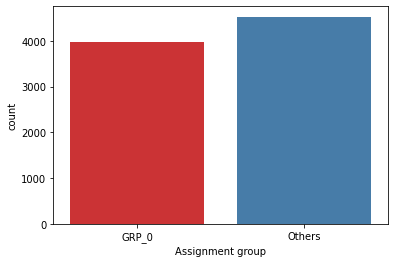

In [ ]:
assignment_group_bin = pd.DataFrame()
assignment_group_bin["Assignment group"] = data["Assignment group"].apply(lambda x: x if x == 'GRP_0' else 'Others')
chart = sns.countplot(
    data=assignment_group_bin,
    x='Assignment group',
    palette='Set1'
)

In [ ]:
#Creating copy for backup
data_orig = data.copy()

Figuring out null values in the corpus and replacing it with unknown for now

In [ ]:
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
data["Description"].fillna("Unknown", inplace = True) 
data["Short description"].fillna("Unknown", inplace = True) 

In [ ]:
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
!pip install googletrans

In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
!pip install langdetect

### **Preprocessing Data**

Checking if short description and description are same. If so we only take Description or else we merge two columns 

In [ ]:
for (i, row) in data.iterrows():
  if row["Short description"] == row["Description"]: 
    data.loc[i,'Full Desc'] = row["Description"]
  else:
    data.loc[i,'Full Desc'] = str(row["Short description"]) + ' ' + str(row["Description"])

In [ ]:
data.head()

,Short description,Description,Caller,Assignment group,Full Desc
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn \r\n\r\nreceived from: eylq...
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error


In [ ]:
#Test case
count = 0
for i,row in enumerate(data["Full Desc"]):
    if data["Full Desc"][i].isspace():
       count = count+1
       print(count)
       #data["Full Desc"][i] = "Unknown"

**Testing the cleaning part on dummy text first**

In [ ]:
####### Dummy Text to check the cleaning part. 
a = '''
:\/"'?#",<>.;{|=+-*&^%$@!} : \ / " ' ? # " , < > . ; { | = + - * & ^ % $ @ ! }
1234 please insert the delivery note no. in erp book
"
     AAB Ab B       bbAb                 \n
received from: gjtyswkb.dpvaymxr@gmail.com
æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸èƒ½åœ¨æ‰‹åŠ¨æˆ–åˆ†å¸ƒäº‹ç‰©æ–¹å¼ä¸‹åˆ›å»ºæ–°çš„é“¾æŽ¥"


would you pls help to check dn 9169636308,the t/o can not generated, "
ms office 365 pro plus french has  got corrupted please do the need full 
"also my initial is wrong, the right one is waitgr chdffong, sdfgwon

a termination for  lauredwwden hwffiglhkins, 11139101, effective 10/01/2016 has been approved. 
"received from: monitoring_tool@company.com

job Job_3050 failed in job_scheduler at: 10/18/2016 22:38:00"
"received from: monitoring_tool@company.com

job SID_37hoti failed in job_scheduler at: 10/18/2016 22:18:00"
"from:  [mailto:system@hr_tool.com] 
sent: wednesday, october 19, 2016 12:52 am
to: nwfodmhc exurcwkm nwfodmhc exurcwkm 
subject:  the terminate action for phvwitud kvetadzo has completed.
 hello , 
nwfodmhc    
   a aa exurcwkm
a termination for phvwitud kvetadzo, 1113235650, effective 09/24/2016 has been approved. 

click the link to view. 
referring to the attached file, using /pweaver/ship-manifest, i can't extract the tracking numbers based on dns.
would you please let me know if there is any way ?
can we not extract the old data ?

"
'''

In [ ]:
call = 'nwfodmhc exurcwkm'

In [ ]:
#clean_initial =pd.DataFrame()
def process_clean(text,caller):
  text = text.lower()
  #multi space removal
  text = re.sub(' +', ' ', text)
  #removing emails
  text = re.sub(r"\S*@\S*\s?"," ", text)
  text = re.sub(r"received from:",' ',text)
  text = re.sub(r"from:",' ',text)
  text = re.sub(r"to:",' ',text)
  text = re.sub(r"subject:",' ',text)
  text = re.sub(r"sent:",' ',text)
  text = re.sub(r"ic:",' ',text)
  text = re.sub(r"cc:",' ',text)
  text = re.sub(r"bcc:",' ',text)
  #replace hyperlinks / url
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
  text = re.sub(r'#([^\s]+)', r'\1', text)

  #remove caller from text
  name_surname = caller.split()
  text = re.sub(name_surname[0],'',text)
  text = re.sub(name_surname[1],'',text)

  #removing digits which doesn't have a a-z or underscore to retrive JOB_0-9 because it will help in classification
  text = re.sub(r"\W\d+", '', text)

  #remove mentioned characters
  text = re.sub("[:\\/'?#\"\",<>().;{|=&^%$@!}\+\-\*]",' ',text)
  text = text.replace("\\",'')

  #multi space removal
  text = re.sub(' +', ' ', text)
 
  #Removes unicode strings like "\u002c" and "x96" """ -------------------------after lang translation
  #text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
  #text = re.sub(r'[^\x00-\x7f]',r'',text)

  #remove all special characters ----------------------------------- cannot perform this since it will important chars which we wil be translating to english
  #text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  
  #removing single character -----------------------------------after translaion
  #text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

  #remove multiple spaces / Whitespace (space, tab, newline)
  text = re.sub(r"\s+"," ", text, flags = re.I)

  #remove space from start and end
  #text = re.sub(r"^\s+", "", text)
  # Remove new line characters 
  #text = re.sub(r'\n',' ',text)

  text = text.strip()
  return text
#clean_test["Description"] = data["Full Desc"].apply(process_clean)
#clean_test["Assignment group"] = data["Assignment group"]

In [ ]:
# Trying the cleaning process on dummy text
b = process_clean(a,call)
b

'please insert the delivery note no in erp book aab ab b bbab æ‰“å¼€å·²å…³é—\xadçš„é”€å”®è®¢å\x8d•æ—¶ï¼œæ˜¾ç¤º ä¸\x8dèƒ½åœ¨æ‰‹åš¨æˆ–åˆ†å¸ƒäº‹ç‰©æ–¹å¼\x8fä¸‹åˆ›å»ºæ–°çš„é“¾æž¥ would you pls help to check dn the t o can not generated ms office pro plus french has got corrupted please do the need full also my initial is wrong the right one is waitgr chdffong sdfgwon a termination for lauredwwden hwffiglhkins effective has been approved job job_3050 failed in job_scheduler at job sid_37hoti failed in job_scheduler at wednesday october am the terminate action for phvwitud kvetadzo has completed hello a aa a termination for phvwitud kvetadzo effective has been approved click the link to view referring to the attached file using pweaver ship manifest i can t extract the tracking numbers based on dns would you please let me know if there is any way can we not extract the old data'

**`Initial Cleaning on the dataset `**

In [ ]:
#Initial cleaning

data["Full Desc"] = data.apply(lambda x: process_clean(x["Full Desc"],x["Caller"]) ,axis=1)

In [ ]:
data.head()

,Short description,Description,Caller,Assignment group,Full Desc
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee man...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook hello team my meetings skype meetings ...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn hi i cannot log on to vpn best
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error


**Detecting Language**


In [ ]:
from langdetect import detect
for (i, j) in data.iterrows():
  try:
    data.loc[i,"language"]= detect(j["Full Desc"])  #.apply(detect)
  except:
    print(j["Full Desc"])
    data.loc[i,"language"] = "Not Recognized" 

In [ ]:
data['language'].value_counts()

en    6735
de     395
sl     274
af     272
it     147
fr     142
da      82
no      81
sv      75
ca      61
nl      59
es      57
pt      31
ro      18
tl      14
pl      13
cy      12
et       7
tr       5
fi       5
sk       3
id       3
hr       3
lt       2
sq       1
cs       1
lv       1
so       1
Name: language, dtype: int64

In [ ]:
data.head()

,Short description,Description,Caller,Assignment group,Full Desc,language
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee man...,en
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook hello team my meetings skype meetings ...,en
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn hi i cannot log on to vpn best,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,no


**Translating language to English if the lang is not en or is not recognized**

In [ ]:
for (i, row) in data.iterrows():
  if row["language"] != 'en' or row["language"] != 'Not Recognized': 
    data.loc[i,'Full Desc'] = translator.translate(row['Full Desc'], dest='en').text

In [ ]:
data.head()

,Short description,Description,Caller,Assignment group,Full Desc,language
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue verified user details employee man...,en
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook hello team my meetings skype meetings ...,en
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn hi i cannot log on to vpn best,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,no


In [ ]:
data["Updated Lang"]= data["Full Desc"].apply(detect)

*Here we observe that few hundred records are converted to english. But the lang detecter still detects some text as other language. Checked the data for other lang it looks like english words*

In [ ]:
data['Updated Lang'].value_counts()

en    7323
af     287
de     156
it     141
fr     113
sv      83
da      75
no      67
es      60
ca      39
nl      36
sl      25
pt      24
ro      15
tl       9
cy       9
pl       9
et       5
tr       5
fi       5
id       4
hr       2
lt       2
sk       2
so       1
hu       1
cs       1
sq       1
Name: Updated Lang, dtype: int64

**Post translation cleaning data (Part 2 on cleaning)**

In [ ]:
#clean_initial =pd.DataFrame()
def post_trans_clean(text):
 
  #removing digits which doesn't have a a-z or underscore 
  text = re.sub(r"\W\d+", '', text)

  #remove mentioned characters
  text = re.sub("[:\\/'?#\"\",<>().;{|=&^%$@!}\+\-\*]",' ',text)

  #Removes unicode strings like "\u002c" and "x96" """ -------------------------after lang translation
  text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
  text = re.sub(r'[^\x00-\x7f]',r'',text)
  
  #removing single character -----------------------------------after translaion
  text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

  #remove multiple spaces / Whitespace (space, tab, newline)
  text = re.sub(r"\s+"," ", text, flags = re.I)
 
  return text

In [ ]:
data["Full Desc"] = data.apply(lambda x: post_trans_clean(x["Full Desc"]) ,axis=1)

In [ ]:
#Checking group with majority sentence as scrape language 
print(data["Full Desc"].loc[data['Assignment group']=='GRP_48'])

1081                                                     
1700                                                     
1701                                                     
1704                                                     
1710                                                st6p 
1711                                                     
1712                                     outlook outlook 
3010                                                 kgkg
3705    security incidents in33932723 possible daserf ...
3738                                                     
3740                                          ups psfups 
4501                                                     
4502                                                     
4503                                                     
5146                                        walkme walkme
5147                                                     
5761                                                     
5762          

In [ ]:
data["Full Desc"][450:500]

450    please reactivate account ewel8323865 laptop f...
451    sales manager views in business objects explor...
452    reset passwords for using password_management_...
453                                 problems with erpgui
454                           support for thrydsss funke
455            illustrated tape exchange printer we68678
456    primary telephone flow down company eu eu plan...
457    bobj access not working hello can now enter bo...
458    bobj access for sales managers team my sales m...
459    skpe addon gone skpe addon gone ______________...
460    job job_593 failed in job_scheduler at job job...
461    hpqc delivers error message user is not mainta...
462    job job_495 failed in job_scheduler at job job...
463    phone gigaset m2 ex professional tel ld no lon...
464    please setup user trhdaa2 back to startpasswor...
465    erp change of new costs not working in cockpit...
466                            user wk_ksem15462 blocked
467    timerecording terminals 

Lemmatizing the data 

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemma(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

#Lemmatizer
data["Full Desc"] = data["Full Desc"].apply(lambda x: lemma(x))

In [ ]:
processed_data = data.copy()

In [ ]:
data["Full Len"] = data["Full Desc"].str.len()
(data["Full Len"]).min(),(data["Full Len"]).max()

(0, 6612)

In [ ]:
data[data["Full Len"]<1].count()

Short description    33
Description          33
Caller               33
Assignment group     33
Full Desc            33
language             33
Updated Lang         33
Full Len             33
dtype: int64

In [ ]:
#data["Assignment group"][data["Full Len"]<1]

In [ ]:
## Creating output of clean dataset for others the gorup to use. 
data.to_csv(r'data_for_modeling.csv',header=True)

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

Reimporting the clean dataset to avoid executing preprocessing

In [ ]:
data = pd.read_csv("data_for_modeling.csv")

In [ ]:
data.head()

,Unnamed: 0,Short description,Description,Caller,Assignment group,slen,dlen,Full Desc,language,Updated Lang,Full Len
0,0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,11,206,login issue verified user detail employee mana...,en,en,198
1,1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,7,194,outlook received from hello team my meeting sk...,en,en,154
2,2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,18,87,cant log in to vpn received from hi cannot log...,en,en,61
3,3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29,29,unable to access hr_tool page,en,en,29
4,4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,12,skype error,no,no,11


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         8500 non-null   int64 
 1   Short description  8500 non-null   object
 2   Description        8500 non-null   object
 3   Caller             8500 non-null   object
 4   Assignment group   8500 non-null   object
 5   slen               8500 non-null   int64 
 6   dlen               8500 non-null   int64 
 7   Full Desc          8467 non-null   object
 8   language           8500 non-null   object
 9   Updated Lang       8500 non-null   object
 10  Full Len           8500 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 730.6+ KB


Creating the GRP_D as for all the other groups apart from top 5

In [ ]:
grouped = data.groupby(['Assignment group'], sort=False).count().reset_index()
#print(grouped.sort_values('Caller',ascending=False).head(5))
grp_arr = (grouped.sort_values('Caller',ascending=False).head(5))['Assignment group']
print(grp_arr.dtype)
y_test = (data['Assignment group']).to_frame('group')
y_df=(~y_test.group.isin(grp_arr))
for idx in y_test.index:
  if (y_df.loc[idx]):
    y_test.loc[idx,'group'] = 'GRP_D'

#y_test = pd.get_dummies(y_test).values
print(y_test[1:])

object
      group
1     GRP_0
2     GRP_0
3     GRP_0
4     GRP_0
5     GRP_0
...     ...
8495  GRP_D
8496  GRP_0
8497  GRP_0
8498  GRP_D
8499  GRP_D

[8499 rows x 1 columns]


In [ ]:
data["Assignment group modified"] = y_test

In [ ]:
#data.to_csv(r'data_modeled.csv',header=True)

In [ ]:
clean_test = pd.DataFrame()
clean_test["Description"] = data["Full Desc"].astype('str')
clean_test["Assignment group"] = data["Assignment group modified"]

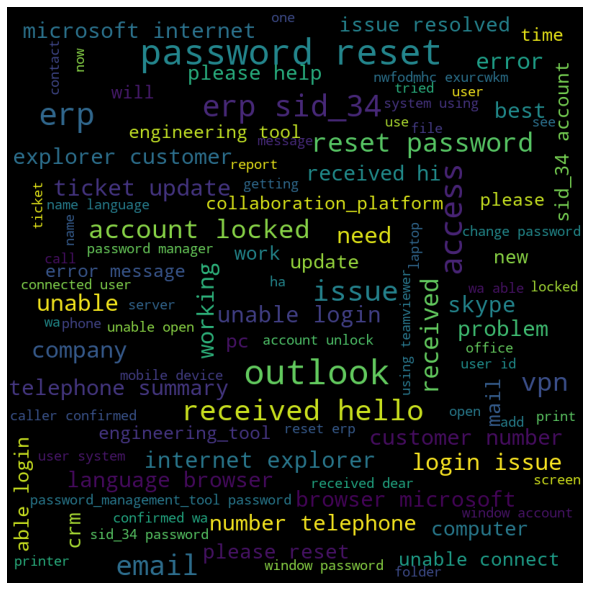

In [ ]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS 


wordcloud = f_word_cloud(x_test1['Full Desc'])
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 



(661, 13)


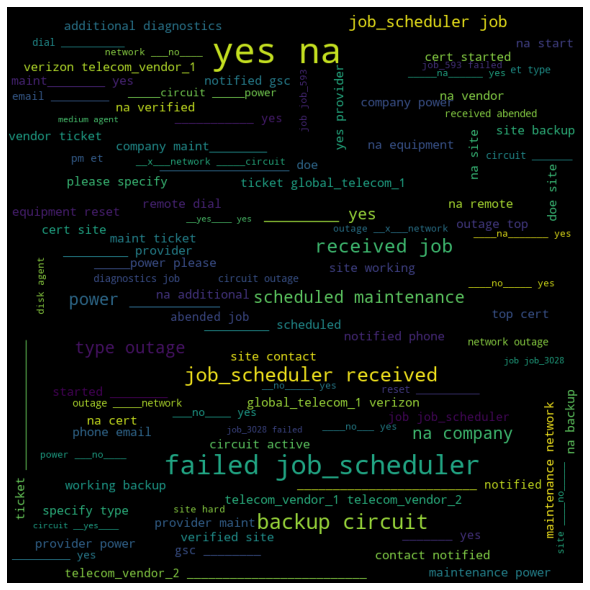

In [ ]:
is_grp8 = data['Assignment group']== 'GRP_8'
# x_test1=x_test[data.Assignment/' 'group.eq('GRP_0')]
x_test2 = data[is_grp8]
print(x_test2.shape)

wordcloud = f_word_cloud(x_test2['Full Desc'])
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

(289, 13)


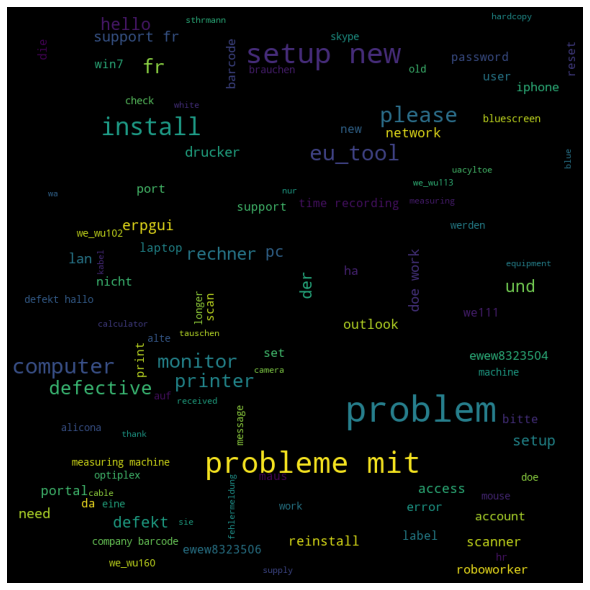

In [ ]:
is_grp24 = data['Assignment group']== 'GRP_24'
# x_test1=x_test[data.Assignment/' 'group.eq('GRP_0')]
x_test3 = data[is_grp24]
print(x_test3.shape)

wordcloud = f_word_cloud(x_test3['Full Desc'])
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

(257, 13)


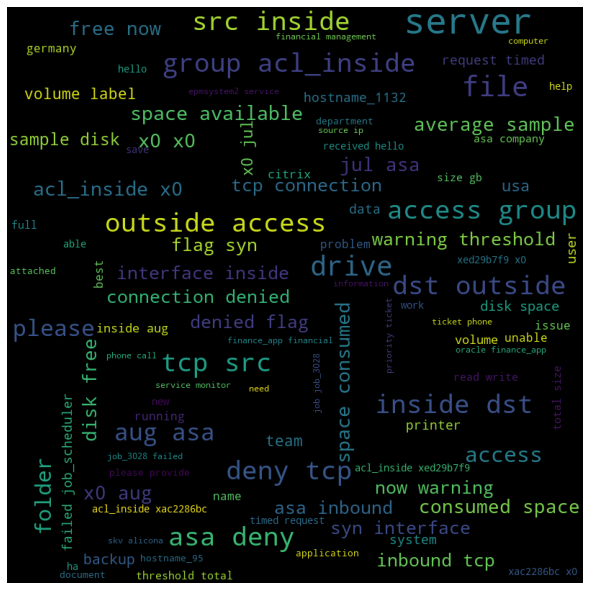

In [ ]:
is_grp12 = data['Assignment group']== 'GRP_12'
# x_test1=x_test[data.Assignment/' 'group.eq('GRP_0')]
x_test4 = data[is_grp12]
print(x_test4.shape)

wordcloud = f_word_cloud(x_test4['Full Desc'])
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

(252, 13)


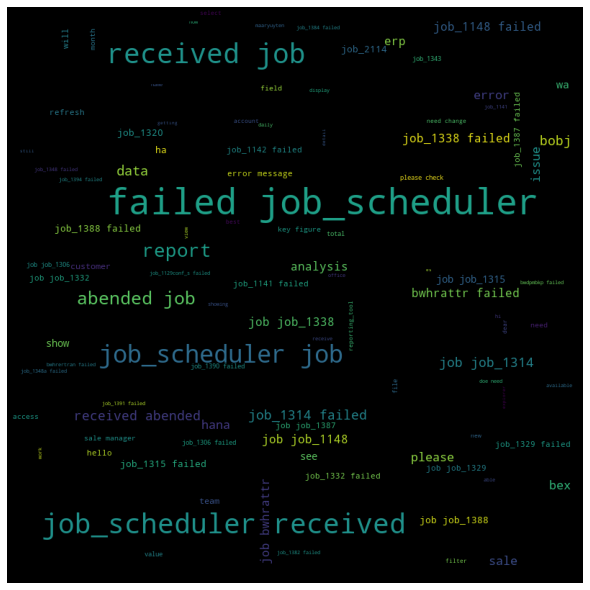

In [ ]:
is_grp9 = data['Assignment group']== 'GRP_9'
# x_test1=x_test[data.Assignment/' 'group.eq('GRP_0')]
x_test5 = data[is_grp9]
print(x_test5.shape)

wordcloud = f_word_cloud(x_test5['Full Desc'])
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### **Random Forest Classifier**

In [ ]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

In [ ]:
import re
df['Full Desc modified'] = [re.sub(r"\d+","" , e) for e in df['Full Desc'].apply(str)]

In [ ]:
maxlen = 150
numWords = 16924
tokenizer,X = wordTokenizer(df['Full Desc modified'])
y = np.asarray(df['Assignment group modified'])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Number of train Samples:", len(X_train))
print("Number of val Samples:", len(X_test))

In [ ]:
from sklearn import metrics
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

### **Bi-Directional LSTM using Custom Embedding**

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
clean_test["Assignment group final"] = labelencoder.fit_transform(clean_test["Assignment group"])

In [ ]:
#This gives error because it's still a string (will convert to number so no need of label encoder)
#clean_test["group"] = clean_test["Assignment group"].str[4:]
clean_test

,Description,Assignment group,Assignment group final
0,login issue verified user detail employee mana...,GRP_0,0
1,outlook received from hello team my meeting sk...,GRP_0,0
2,cant log in to vpn received from hi cannot log...,GRP_0,0
3,unable to access hr_tool page,GRP_0,0
4,skype error,GRP_0,0
...,...,...,...
8495,email not coming in from zz mail received from...,GRP_D,5
8496,telephony software issue,GRP_0,0
8497,vip2 window password reset for tifpdchb pedxruyf,GRP_0,0
8498,machine no est funcionando am unable to access...,GRP_D,5


In [ ]:
clean_test.isna().sum()

Description               0
Assignment group          0
Assignment group final    0
dtype: int64

In [ ]:
# max_features = 1000
# maxlen = 1000
# embedding_size = 200
EMBEDDING_DIMENSION = 64
VOCABULARY_SIZE = 2000
MAX_LENGTH = 100
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(clean_test["Description"])
X = tokenizer.texts_to_sequences(clean_test["Description"])


In [ ]:
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
dict(list(word_index.items())[0:10])

Vocabulary size: 14350


{'<OOV>': 1,
 'and': 9,
 'from': 6,
 'in': 5,
 'is': 7,
 'job': 4,
 'no': 8,
 'not': 10,
 'the': 3,
 'to': 2}

In [ ]:
X = pad_sequences(X,maxlen=MAX_LENGTH)
Y = np.asarray(clean_test["Assignment group final"])
print(len(X[0]))

100


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_article(text):
 return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X[11]))

In [ ]:
from keras.layers import Dense, Embedding, LSTM,GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          918464    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, None, 64)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)               

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 44)

In [ ]:
num_epochs = 4
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test), verbose=2)

Epoch 1/4
213/213 - 156s - loss: 1.0657 - accuracy: 0.5788 - val_loss: 0.8042 - val_accuracy: 0.6853
Epoch 2/4
213/213 - 157s - loss: 0.7777 - accuracy: 0.7071 - val_loss: 0.7338 - val_accuracy: 0.7182
Epoch 3/4
213/213 - 158s - loss: 0.6850 - accuracy: 0.7478 - val_loss: 0.6975 - val_accuracy: 0.7424
Epoch 4/4
213/213 - 157s - loss: 0.6307 - accuracy: 0.7635 - val_loss: 0.7144 - val_accuracy: 0.7312


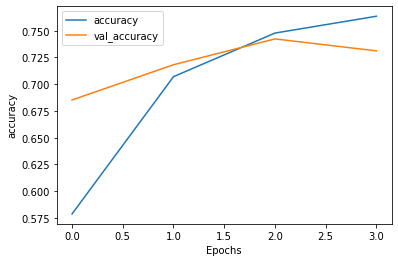

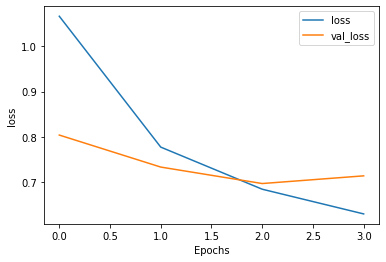

In [ ]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
graph_plots(history, "accuracy")
graph_plots(history, "loss")

### **Bi-Directional LSTM with Glove Embedding**


In [ ]:
x_test= pd.DataFrame(data['Full Desc'])
x_test['Full Desc']  = x_test['Full Desc'].astype('str')
y_test = data['Assignment group modified'].to_frame('group')

y_test = pd.get_dummies(y_test).values
print(y_test[1],data['Assignment group modified'][1])


[1 0 0 0 0 0] GRP_0


In [ ]:
print(x_test['Full Desc'][0].split(' '))

['login', 'issue', 'verified', 'user', 'detail', 'employee', 'manager', 'name', 'checked', 'the', 'user', 'name', 'in', 'ad', 'and', 'reset', 'the', 'password', 'advised', 'the', 'user', 'to', 'login', 'and', 'check', 'caller', 'confirmed', 'that', 'he', 'wa', 'able', 'to', 'login', 'issue', 'resolved']


In [ ]:
import tensorflow.keras as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

max_features = 5000

tokenizer = tf.preprocessing.text.Tokenizer( num_words=max_features,lower=False, split=' ', char_level=False, oov_token=None)
texts = tokenizer.fit_on_texts(
     x_test['Full Desc']
 )
sequences = tokenizer.texts_to_sequences(
     x_test['Full Desc']
)
#print(sequences)
desc_seq = tokenizer.get_config()
print(desc_seq)
vocab = tokenizer.word_index

{'num_words': 5000, 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': None, 'document_count': 8500, 'word_counts': '{"login": 722, "issue": 1383, "verified": 187, "user": 1598, "detail": 262, "employee": 233, "manager": 359, "name": 731, "checked": 88, "the": 7245, "in": 4927, "ad": 120, "and": 2720, "reset": 1207, "password": 2104, "advised": 55, "to": 7847, "check": 383, "caller": 91, "confirmed": 122, "that": 842, "he": 252, "wa": 616, "able": 475, "resolved": 130, "outlook": 723, "received": 2398, "from": 3520, "hello": 693, "team": 427, "my": 1159, "meeting": 111, "skype": 399, "etc": 56, "are": 893, "not": 2719, "appearing": 23, "calendar": 47, "can": 987, "somebody": 2, "please": 2245, "advise": 99, "how": 138, "correct": 93, "this": 1596, "kind": 86, "cant": 35, "log": 425, "vpn": 465, "hi": 410, "cannot": 406, "on": 2627, "best": 351, "unable": 1044, "access": 1384, "hr": 242, "tool": 1550, "page": 127, "error": 

In [ ]:
maxlen=max(len(t) for t in sequences)
print(maxlen)
#maxlen=1500 #Hardcoding length to 1500
data_df = tf.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding='post',truncating='post')

966


In [ ]:
num_words = len(tokenizer.word_index) + 1
embedding_size=100
#print(num_words)

# embeddings_index = {}
# f = open(os.path.join('/content/drive/My Drive/NLP/', 'glove.6B.100d.txt'))
EMBEDDING_FILE = '/content/drive/My Drive/NLP' + '/glove.6B.'+str(embedding_size)+'d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))


for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.11996     0.68728     0.80487001 ...  0.067353    0.65083998
   0.30028   ]]


In [ ]:
#from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from tensorflow.keras import activations

lstm_out = 196

embedding_layer = Embedding(num_words,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
#,return_sequences=True
#model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(200,activation=tf.layers.LeakyReLU(alpha=0.2)))
model.add(Dense(100,activation=tf.layers.LeakyReLU(alpha=0.2)))
model.add(Dense(6,activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 966, 100)          1439200   
_________________________________________________________________
bidirectional (Bidirectional (None, 392)               465696    
_________________________________________________________________
dense (Dense)                (None, 200)               78600     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 2,004,202
Trainable params: 565,002
Non-trainable params: 1,439,200
_________________________________________________________________
None


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_df, y_test, test_size=0.30)
print(X_train.shape)
print(X_test.shape)

(5950, 966)
(2550, 966)


In [ ]:
import os
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 6, batch_size=batch_size, verbose = 2,validation_split=0.2,callbacks=[cp_callback])

Epoch 1/6

Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt
149/149 - 1347s - loss: 0.9369 - accuracy: 0.6126 - val_loss: 0.7972 - val_accuracy: 0.6748
Epoch 2/6

Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt
149/149 - 1331s - loss: 0.7250 - accuracy: 0.6952 - val_loss: 0.6937 - val_accuracy: 0.7042
Epoch 3/6

Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt
149/149 - 1336s - loss: 0.6368 - accuracy: 0.7489 - val_loss: 0.6881 - val_accuracy: 0.7176
Epoch 4/6

Epoch 00004: saving model to /content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt
149/149 - 1336s - loss: 0.5807 - accuracy: 0.7655 - val_loss: 0.6568 - val_accuracy: 0.7328
Epoch 5/6

Epoch 00005: saving model to /content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/lstm_model/cp.ckpt
149/149 - 1345s - loss: 0.5411 - accuracy: 0.7803 - val_l

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

80/80 - 85s - loss: 0.6003 - accuracy: 0.7616
score: 0.60
acc: 0.76


In [ ]:
import numpy as np
var=1
print(X_test[var].shape)
result = model.predict(X_test[var],batch_size=1,verbose = 2)[0]
print( "Predicted output:",result,np.argmax(result))
print("Actual output",Y_test[var])

(966,)
966/966 - 1s
Predicted output: [1.01516135e-01 1.94088451e-03 3.13569196e-02 8.06762255e-04
 2.09625741e-03 8.62283111e-01] 5
Actual output [0 0 0 0 0 1]


### **Fasttext for Text Classification**

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 1.8MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3028180 sha256=d553fb4bdf89d38d1be1d8cd80f2541a9924f17bce1c12328fac2812563791cb
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext
import sys
from sklearn.model_selection import train_test_split
conv_df  = pd.DataFrame()
conv_df['labels'] = '__label__' + data['Assignment group modified']
list_of_tuples = list(zip(conv_df['labels'], data['Full Desc']))  
df = pd.DataFrame(list_of_tuples, columns = ['Assignment group', 'Description'])  

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df, df['Assignment group'], test_size = 0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6800 entries, 6585 to 3439
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Assignment group  6800 non-null   object
 1   Description       6779 non-null   object
dtypes: object(2)
memory usage: 159.4+ KB


In [ ]:
np.savetxt('fastText_train.txt', X_train.values, fmt='%s')  

In [ ]:
model = fasttext.train_supervised(input="fastText_train.txt", lr=0.1, epoch=400)

In [ ]:
np.savetxt('fastText_test.txt', X_test.values, fmt='%s')  
model.test("fastText_test.txt")

(1700, 0.7576470588235295, 0.7576470588235295)

In [ ]:
fasttext_model = fasttext.load_model('fasttext.bin')

In [ ]:
fasttext_model.predict('job job_504 failed in job_scheduler')

(('__label__GRP_8',), array([0.99884933]))

In [ ]:
# conv_df['labels'] = '__label__' + conv_df['Assignment group modified']
# list_of_tuples = list(zip(conv_df['labels'], conv_df['Full Desc']))  
# df = pd.DataFrame(list_of_tuples, columns = ['Assignment group', 'Description'])  
df['labels'] = '__label__' + df['Assignment group']
list_of_tuples = list(zip(df['labels'], df['Description']))  
df_ft = pd.DataFrame(list_of_tuples, columns = ['Assignment group', 'Description'])  
df_ft.head()

,Assignment group,Description
0,__label__GRP_0,-verified user details.(employee# & manager na...
1,__label__GRP_0,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...
2,__label__GRP_0,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...
3,__label__GRP_0,unable to access hr_tool page
4,__label__GRP_0,skype error


In [ ]:
top_10 = list(df_ft.groupby("Assignment group").size().reset_index().sort_values(by=0,ascending=False)[:10]["Assignment group"].values)
df_ft_10 = df_ft[df_ft["Assignment group"].isin(top_10)].copy(deep=True)

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(df, df['Assignment group'], test_size = 0.3)
X_train, X_test, Y_train, Y_test = train_test_split(df_ft_10, df_ft_10['Assignment group'], test_size = 0.2)
X_train_v, X_val, Y_train_v, Y_val = train_test_split(X_train, X_train['Assignment group'], test_size = 0.20)

In [ ]:
print(X_train.shape,X_train_v.shape, X_val.shape,X_test.shape)

(5129, 2) (4103, 2) (1026, 2) (1283, 2)


In [ ]:
# ENTIRE TRAIN DATA
np.savetxt('ft_train.txt', X_train.values, fmt='%s')

#TRAIN DATA FOR VALIDATION
np.savetxt('ft_train_v.txt', X_train_v.values, fmt='%s')
#VALIDATION SET
np.savetxt('ft_val.txt', X_val.values, fmt='%s')

# Test set
np.savetxt('ft_test.txt', X_test.values, fmt='%s')

In [ ]:
model_lr1_e100 = fasttext.train_supervised(input="ft_train.txt", lr=0.1,epoch=20, bucket=200000, dim=50, loss='hs')

In [ ]:
model_lr1_e100.test("ft_test.txt")

(1283, 0.7872174590802806, 0.7872174590802806)

In [ ]:
model_lr1_e100.predict('unable access machine utility finish drawer adjustment setting network')

(('__label__GRP_0',), array([0.99005729]))

### **BERT Model**

In [ ]:
#!apt-get install python3.4

In [ ]:
# !pip install pytorch_pretrained_bert pytorch-nlp
# !pip install transformers

In [ ]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

torch.cuda.is_available()

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import os
import numpy as np
import pandas as pd
#import json as js

project_path = '/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A'

In [ ]:
data = pd.read_csv (r'/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_modeled.csv')
print (data.head(5))
print(data.dtypes)

   Unnamed: 0  Unnamed: 0.1              Short description  \
0           0             0                    login issue   
1           1             1                        outlook   
2           2             2             cant log in to vpn   
3           3             3  unable to access hr_tool page   
4           4             4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  slen  dlen  \
0            GRP_0    11   206   
1            GRP_0     7   194   
2            GRP_0    18    87   
3            GRP_0    29    29   
4     

In [ ]:
data1 = pd.DataFrame();
data1['idx'] = data.index
data1['labels'] = data['Assignment group modified']
data1['sentence'] = data['Full Desc']
data1.dropna(how='any',inplace=True)
print(data1.head(10))

   idx labels                                           sentence
0    0  GRP_0  login issue verified user detail employee mana...
1    1  GRP_0  outlook received from hello team my meeting sk...
2    2  GRP_0  cant log in to vpn received from hi cannot log...
3    3  GRP_0                      unable to access hr_tool page
4    4  GRP_0                                        skype error
5    5  GRP_0     unable to log in to engineering tool and skype
6    6  GRP_D  event critical hostname_221 company com the va...
7    7  GRP_0  ticket_no1550391 employment status new non emp...
8    8  GRP_0                unable to disable add in on outlook
9    9  GRP_0                    ticket update on inplant_874773


In [ ]:
data1['labels'].count()
data1.groupby(['labels']).count()

,idx,sentence
labels,,
GRP_0,3976,3976
GRP_12,257,257
GRP_24,289,289
GRP_8,661,661
GRP_9,252,252
GRP_D,3032,3032


In [ ]:
grp12=data1[data1['labels']=='GRP_12']
grp24=data1[data1['labels']=='GRP_24']
grp9=data1[data1['labels']=='GRP_9']
grp8=data1[data1['labels']=='GRP_8']
#grp12.shape
for i in range(11):
  data1=data1.append(grp12)
  data1=data1.append(grp24)
  data1=data1.append(grp9)
for i in range(4):
  data1=data1.append(grp8)
data1.shape

(19889, 3)

In [ ]:
data1 = data1.sample(frac=1).reset_index(drop=True)

In [ ]:
possible_labels = data1.labels.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'GRP_24': 0, 'GRP_12': 1, 'GRP_9': 2, 'GRP_8': 3, 'GRP_D': 4, 'GRP_0': 5}

In [ ]:
data1['label'] = data1.labels.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data1.index.values, 
                                                  data1.label.values, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify=data1.label.values)

In [ ]:
data1['data_type'] = ['not_set']*data1.shape[0]

data1.loc[X_train, 'data_type'] = 'train'
data1.loc[X_val, 'data_type'] = 'val'

data1.groupby(['labels', 'label', 'data_type']).count()

idx  sentence
labels label data_type                
GRP_0  5     train      2783      2783
             val        1193      1193
GRP_12 1     train      2159      2159
             val         925       925
GRP_24 0     train      2428      2428
             val        1040      1040
GRP_8  3     train      2313      2313
             val         992       992
GRP_9  2     train      2117      2117
             val         907       907
GRP_D  4     train      2122      2122
             val         910       910

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
                                        
encoded_data_train = tokenizer.batch_encode_plus(
    data1[data1.data_type=='train'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data1[data1.data_type=='val'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data1[data1.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data1[data1.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_volume_bert/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_volume_bert/finetuned_BERT_epoch_3.model', map_location=device))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: GRP_24
Accuracy: 1040/1040

Class: GRP_12
Accuracy: 925/925

Class: GRP_9
Accuracy: 907/907

Class: GRP_8
Accuracy: 946/992

Class: GRP_D
Accuracy: 622/910

Class: GRP_0
Accuracy: 1047/1193



In [ ]:
from sklearn.metrics import accuracy_score

def accuracy_per_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    acc = accuracy_score(labels_flat, preds_flat)
    print(f'Total Accuracy: {acc*100}%\n')

In [ ]:
accuracy_per_per_class(predictions, true_vals)

Total Accuracy: 91.95575666163901%



### **DistilBERT Model**

In [ ]:
#!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
#!pip install transformers

In [ ]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt

import torch
from pytorch_pretrained_bert import BertModel
from tqdm.notebook import tqdm

from transformers import DistilBertTokenizer
from torch.utils.data import TensorDataset

from transformers import DistilBertForSequenceClassification

from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output


torch.cuda.is_available()

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)

Using TensorFlow backend.


In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import os
import numpy as np
import pandas as pd
#import json as js

project_path = '/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A'

In [ ]:
data = pd.read_csv (r'/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_modeled.csv')
print (data.head(5))
print(data.dtypes)

   Unnamed: 0  Unnamed: 0.1              Short description  \
0           0             0                    login issue   
1           1             1                        outlook   
2           2             2             cant log in to vpn   
3           3             3  unable to access hr_tool page   
4           4             4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  slen  dlen  \
0            GRP_0    11   206   
1            GRP_0     7   194   
2            GRP_0    18    87   
3            GRP_0    29    29   
4     

In [ ]:
data1 = pd.DataFrame();
data1['idx'] = data.index
data1['labels'] = data['Assignment group modified']
data1['sentence'] = data['Full Desc']
data1.dropna(how='any',inplace=True)
print(data1.head(10))

   idx labels                                           sentence
0    0  GRP_0  login issue verified user detail employee mana...
1    1  GRP_0  outlook received from hello team my meeting sk...
2    2  GRP_0  cant log in to vpn received from hi cannot log...
3    3  GRP_0                      unable to access hr_tool page
4    4  GRP_0                                        skype error
5    5  GRP_0     unable to log in to engineering tool and skype
6    6  GRP_D  event critical hostname_221 company com the va...
7    7  GRP_0  ticket_no1550391 employment status new non emp...
8    8  GRP_0                unable to disable add in on outlook
9    9  GRP_0                    ticket update on inplant_874773


In [ ]:
data1['labels'].count()
data1.groupby(['labels']).count()

,idx,sentence
labels,,
GRP_0,3976,3976
GRP_12,257,257
GRP_24,289,289
GRP_8,661,661
GRP_9,252,252
GRP_D,3032,3032


In [ ]:
grp12=data1[data1['labels']=='GRP_12']
grp24=data1[data1['labels']=='GRP_24']
grp9=data1[data1['labels']=='GRP_9']
grp8=data1[data1['labels']=='GRP_8']
#grp12.shape
for i in range(11):
  data1=data1.append(grp12)
  data1=data1.append(grp24)
  data1=data1.append(grp9)
for i in range(4):
  data1=data1.append(grp8)
data1.shape

(19889, 3)

In [ ]:
data1 = data1.sample(frac=1).reset_index(drop=True)

In [ ]:
possible_labels = data1.labels.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'GRP_24': 0, 'GRP_12': 1, 'GRP_9': 2, 'GRP_8': 3, 'GRP_D': 4, 'GRP_0': 5}

In [ ]:
data1['label'] = data1.labels.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data1.index.values, 
                                                  data1.label.values, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify=data1.label.values)

In [ ]:
data1['data_type'] = ['not_set']*data1.shape[0]

data1.loc[X_train, 'data_type'] = 'train'
data1.loc[X_val, 'data_type'] = 'val'

data1.groupby(['labels', 'label', 'data_type']).count()

idx  sentence
labels label data_type                
GRP_0  5     train      2783      2783
             val        1193      1193
GRP_12 1     train      2159      2159
             val         925       925
GRP_24 0     train      2428      2428
             val        1040      1040
GRP_8  3     train      2313      2313
             val         992       992
GRP_9  2     train      2117      2117
             val         907       907
GRP_D  4     train      2122      2122
             val         910       910

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_dict),return_dict=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
                                        
encoded_data_train = tokenizer.batch_encode_plus(
    data1[data1.data_type=='train'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


encoded_data_val = tokenizer.batch_encode_plus(
    data1[data1.data_type=='val'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data1[data1.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data1[data1.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
model.to(device)
model.parameters

<bound method Module.parameters of DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dr

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
               
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }    
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.14938519610615536
Validation loss: 0.4034526185544014
F1 Score (Weighted): 0.9063347051458264



Epoch 2
Training loss: 0.1742455683060576
Validation loss: 0.3612614836279768
F1 Score (Weighted): 0.9116689431913001



Epoch 3
Training loss: 0.1319537741663262
Validation loss: 0.37208622813999337
F1 Score (Weighted): 0.9134833516835895



Epoch 4
Training loss: 0.11769527254022098
Validation loss: 0.37208622813999337
F1 Score (Weighted): 0.9134833516835895



Epoch 5
Training loss: 0.11380714598517633
Validation loss: 0.37208622813999337
F1 Score (Weighted): 0.9134833516835895



In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict))

model.to(device)

model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/CPSTN_NLP_GRP6A/data_volume/finetuned_BERT_epoch_5.model', map_location=device))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Class: GRP_24
Accuracy: 1040/1040

Class: GRP_12
Accuracy: 902/925

Class: GRP_9
Accuracy: 907/907

Class: GRP_8
Accuracy: 967/992

Class: GRP_D
Accuracy: 598/910

Class: GRP_0
Accuracy: 1053/1193



In [ ]:
from sklearn.metrics import accuracy_score

def accuracy_per_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    acc = accuracy_score(labels_flat, preds_flat)
    print(f'Total Accuracy: {acc*100}%\n')

In [ ]:
accuracy_per_per_class(predictions, true_vals)

Total Accuracy: 91.62057985587397%

